# 13 - Modelos com Memória

## Imports, loadings and functions

In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
# from causalgraphicalmodels import CausalGraphicalModel  # Just work in < python3.9 

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
# plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

In [5]:
# Utils functions

def logit(p):
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

## 13.1 Example: Multilevel tadpoles

### R Code 13.1

In [6]:
df = pd.read_csv('./data/reedfrogs.csv', sep=";")
df['tank'] = df.index.to_list()
df['tank'] += 1  # index start from 1 like Stan works
df

,density,pred,size,surv,propsurv,tank
0,10,no,big,9,0.900000,1
1,10,no,big,10,1.000000,2
2,10,no,big,7,0.700000,3
3,10,no,big,10,1.000000,4
4,10,no,small,9,0.900000,5
5,10,no,small,9,0.900000,6
6,10,no,small,10,1.000000,7
7,10,no,small,9,0.900000,8
8,10,pred,big,4,0.400000,9
9,10,pred,big,9,0.900000,10


In [7]:
df.describe()

,density,surv,propsurv,tank
count,48.000000,48.000000,48.000000,48.00
mean,23.333333,16.312500,0.721607,24.50
std,10.382746,9.884775,0.266416,14.00
min,10.000000,4.000000,0.114286,1.00
25%,10.000000,9.000000,0.496429,12.75
50%,25.000000,12.500000,0.885714,24.50
75%,35.000000,23.000000,0.920000,36.25
max,35.000000,35.000000,1.000000,48.00


### R Code 13.2

$$ S_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{TANK[i]} $$

$$ \alpha_j \sim Normal(0, 1.5), \mbox{ for } j \in \{1, 48\}$$

In [8]:
model = """
    data {
        int qty;
        array[qty] int N;  // Total quantities that have tadpoles in tank
        array[qty] int survival;  // How many tadpoles survival
        array[qty] int tank;  // Tank index
    }
    
    parameters {
        vector[qty] alpha;
    }
    
    model {
        vector[qty] p;
        
        alpha ~ normal(0, 1.5);
        
        for (i in 1:qty){
            p[i] = alpha[ tank[i] ];
            p[i] = inv_logit(alpha[i]);
        }
        
        survival ~ binomial(N, p);
        
    }
"""

dat_list = {
    'qty': len(df),
    'tank': df['tank'].to_list(),
    'survival': df['surv'].to_list(),
    'N': df['density'].to_list()
}


posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!


In [9]:
model_13_1 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys()
)

In [10]:
az.summary(model_13_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.688,0.769,0.492,2.893,0.009,0.008,7368.0,3077.0,1.0
alpha[1],2.413,0.902,1.062,3.879,0.012,0.010,6390.0,2800.0,1.0
alpha[2],0.754,0.634,-0.287,1.710,0.008,0.008,6016.0,2649.0,1.0
alpha[3],2.416,0.924,0.941,3.781,0.012,0.010,7037.0,2718.0,1.0
alpha[4],1.723,0.762,0.480,2.929,0.011,0.009,5394.0,3054.0,1.0
alpha[5],1.708,0.764,0.457,2.860,0.010,0.009,5989.0,2731.0,1.0
alpha[6],2.372,0.871,0.972,3.754,0.011,0.009,6244.0,3083.0,1.0
alpha[7],1.714,0.783,0.490,2.932,0.011,0.010,5967.0,2391.0,1.0
alpha[8],-0.358,0.613,-1.336,0.585,0.007,0.009,8826.0,2906.0,1.0
alpha[9],1.699,0.760,0.530,2.950,0.010,0.009,6172.0,2938.0,1.0


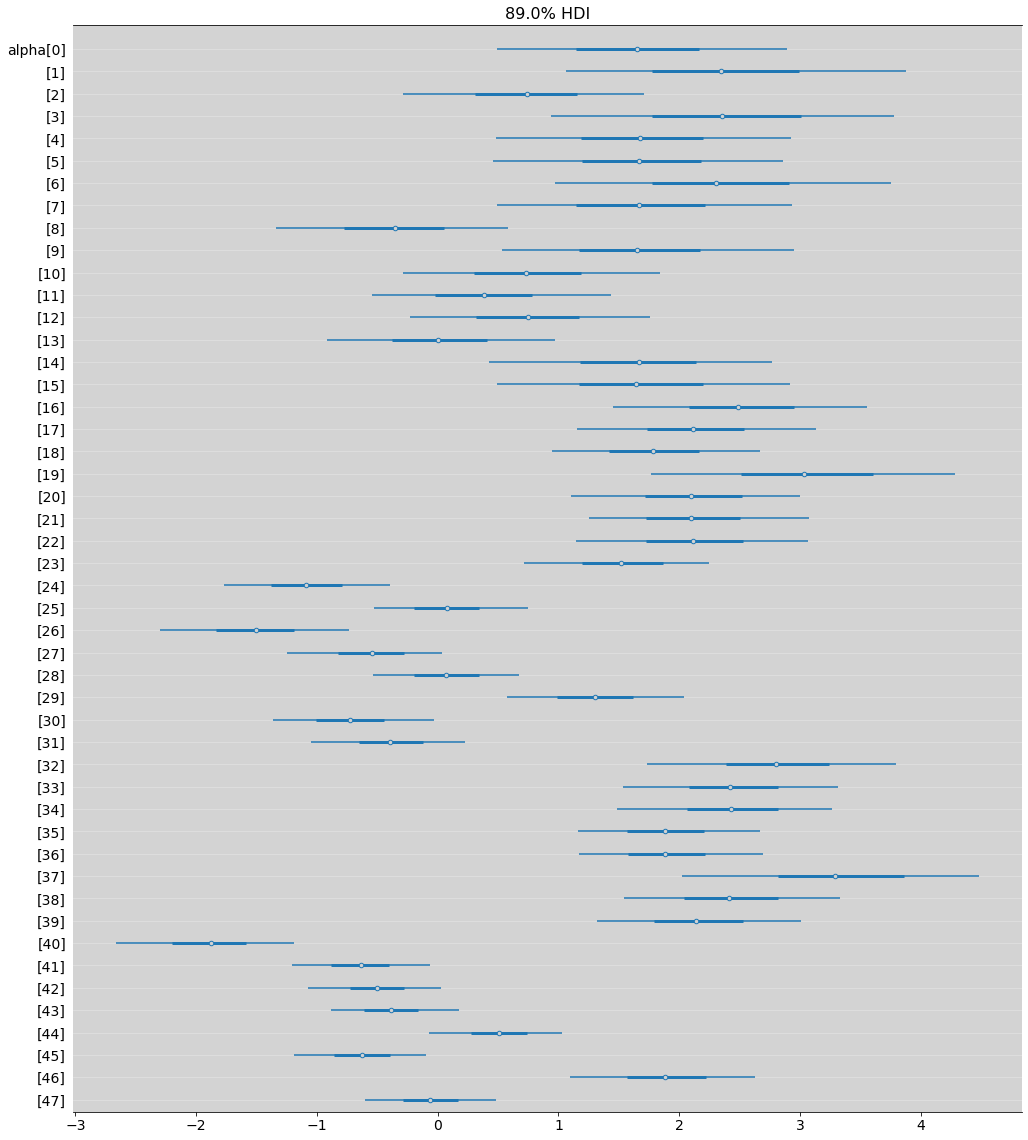

In [11]:
az.plot_forest(model_13_1, hdi_prob=0.89, combined=True, figsize=(17, 20))

plt.grid(axis='y', c='white', alpha=0.3)
plt.show()

### R Code 13.3

#### Multilevel model Tadpole

$$ S_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{TANK[i]} $$

$$ \alpha[j] \sim Normal(\bar{\alpha}, \sigma) \mbox{ - [Adaptative prior]} $$

$$ \bar{\alpha} \sim Normal(0, 1.5) \mbox{ - [prior to average tank]} $$

$$ \sigma \sim Exponential(1) \mbox{ - [prior for standard deviation of tanks]} $$

In [12]:
model = """
    data {
        int qty;
        array[qty] int N;
        array[qty] int survival;
        array[qty] int tank;
    }
    
    parameters {
        vector[qty] alpha;
        real bar_alpha;
        real<lower=0> sigma;
    }
    
    model {
        vector[qty] p;
        
        alpha ~ normal(bar_alpha, sigma);
        
        bar_alpha ~ normal(0, 1.5);
        sigma ~ exponential(1);
        
        for (i in 1:qty){
            p[i] = alpha[ tank[i] ];
            p[i] = inv_logit(p[i]);
        }
    
        survival ~ binomial(N, p);
    }
"""


dat_list = {
    'qty': len(df),
    'tank': df['tank'].to_list(),
    'survival': df['surv'].to_list(),
    'N': df['density'].to_list()
}


posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_e2h0pxzb/model_jyvtw2so.stan', line 18, column 8 to column 41)
  If this warnin

In [13]:
model_13_2 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys(),
)

In [14]:
az.summary(model_13_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.122,0.867,0.761,3.410,0.013,0.011,4670.0,2652.0,1.0
alpha[1],3.057,1.111,1.331,4.780,0.017,0.014,4514.0,2725.0,1.0
alpha[2],1.009,0.668,-0.092,2.014,0.010,0.009,4757.0,2303.0,1.0
alpha[3],3.051,1.134,1.287,4.817,0.019,0.015,3884.0,2546.0,1.0
alpha[4],2.113,0.863,0.775,3.512,0.013,0.011,4661.0,2460.0,1.0
alpha[5],2.124,0.867,0.696,3.413,0.015,0.012,3970.0,2189.0,1.0
alpha[6],3.066,1.125,1.238,4.747,0.019,0.015,4090.0,2394.0,1.0
alpha[7],2.116,0.853,0.751,3.419,0.012,0.010,5383.0,2966.0,1.0
alpha[8],-0.168,0.633,-1.162,0.847,0.009,0.010,4716.0,2678.0,1.0
alpha[9],2.110,0.846,0.743,3.403,0.012,0.010,5010.0,2650.0,1.0


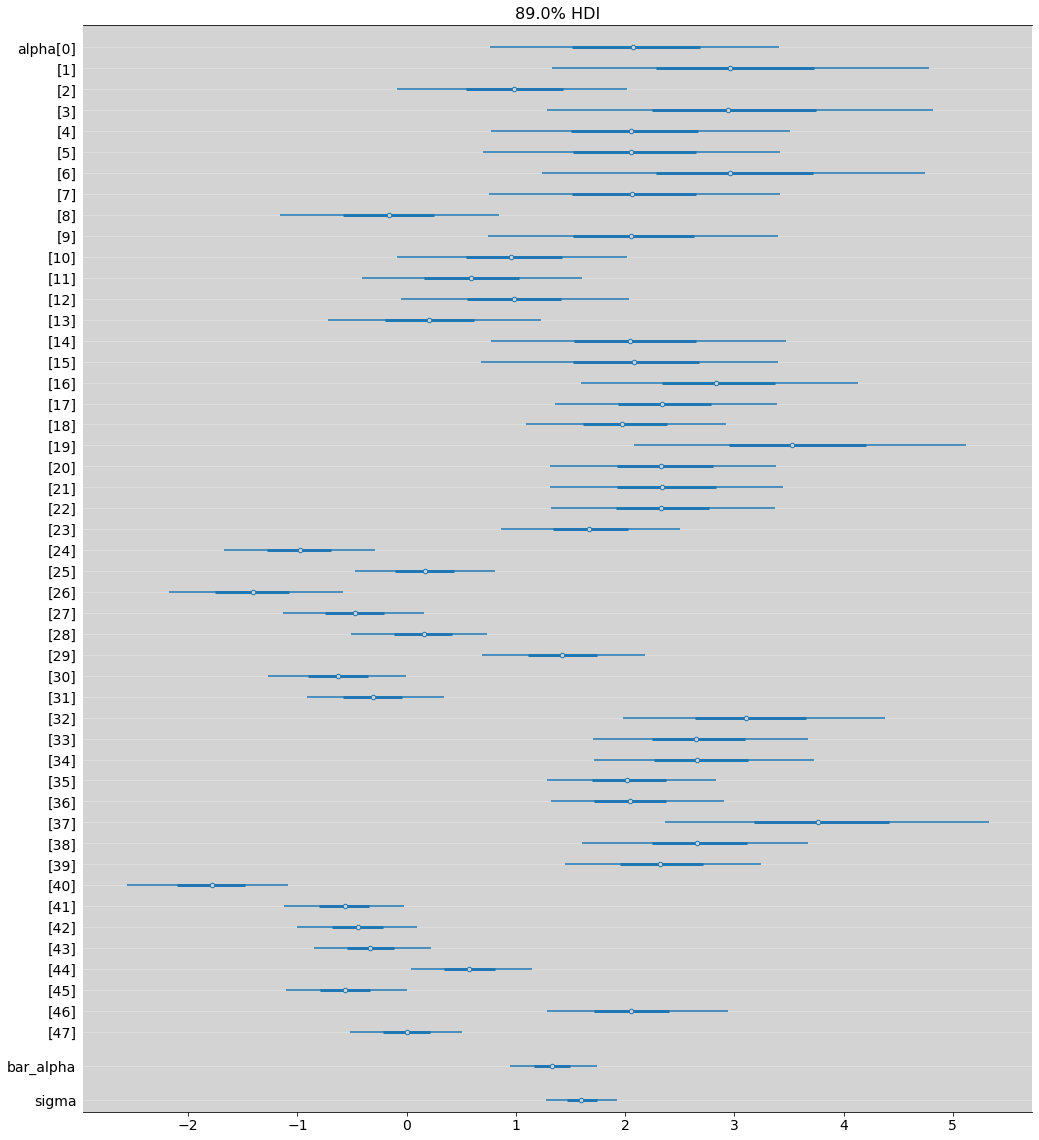

In [15]:
az.plot_forest(model_13_2, hdi_prob=0.89, combined=True, figsize=(17, 20))

plt.grid(axis='y', color='white', alpha=0.3)
plt.show()

### R Code 13.4

In [16]:
# az.compare(model_13_1, model_13_2)

### R Code 13.5

In [17]:
means = [ model_13_2.posterior.alpha.sel(alpha_dim_0=(i-1)).values.flatten().mean() for i in df.tank ]
means = inv_logit(means)

In [18]:
# My test, this is not originaly in book
means_13_1 = [ model_13_1.posterior.alpha.sel(alpha_dim_0=(i-1)).values.flatten().mean() for i in df.tank ]
means_13_1 = inv_logit(means_13_1)

In [19]:
bar_alpha_log = model_13_2.posterior.bar_alpha.values.flatten()
bar_alpha = inv_logit(bar_alpha_log)
bar_alpha_mean = bar_alpha.mean() 

sigma_log = model_13_2.posterior.sigma.values.flatten()
sigma = inv_logit(sigma_log)
sigma_mean = sigma.mean()

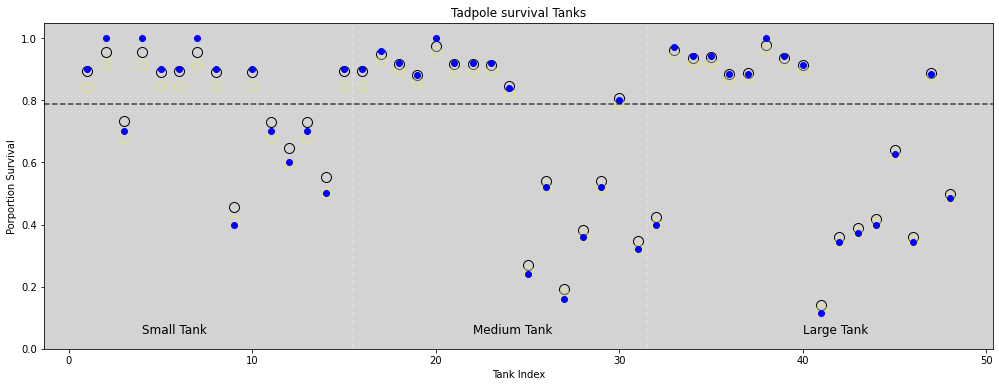

In [20]:
plt.figure(figsize=(17, 6))
plt.ylim = ([0, 1])

plt.scatter(df.tank, means, edgecolors='black', c='lightgray', s=100)
plt.scatter(df.tank, means_13_1, edgecolors='yellow', c='lightgray', s=100, alpha=0.4)
plt.scatter(df.tank, df.propsurv, c='blue')


plt.axvline(x=15.5, ls='--', color='white', alpha=0.3)
plt.axvline(x=31.5, ls='--', color='white', alpha=0.3)

plt.axhline(y=bar_alpha_mean, ls='--', c='black', alpha=0.7)

plt.text(4, 0.05, 'Small Tank', size=12)
plt.text(22, 0.05, 'Medium Tank', size=12)
plt.text(40, 0.05, 'Large Tank', size=12)

plt.gca().set_ylim(0.0, 1.05)

plt.title('Tadpole survival Tanks')
plt.xlabel('Tank Index')
plt.ylabel('Porportion Survival')

plt.show()

- **Blue dot**: Proportion survival s_i/N_i

- **Black circle**: Multilevel model estimative

- **Light Yellow**: No-pooling estimative

### R Code 13.6

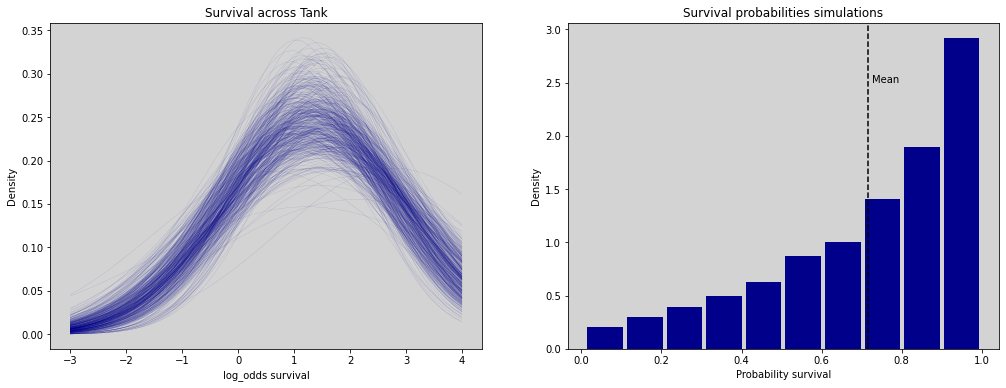

In [21]:
fig = plt.figure(figsize=(17, 6))
gs = GridSpec(1, 2)

x = np.linspace(-3, 4)

s_sampled = 500

ax1 = fig.add_subplot(gs[0, 0])
log_odds_survival = []
log_odds_sampled_index = np.random.choice(len(bar_alpha_log) ,size=s_sampled, replace=False)

for i in log_odds_sampled_index:
    log_odds_survival.append(stats.norm.pdf(x, bar_alpha_log[i], sigma_log[i]))

for i in range(s_sampled):
    ax1.plot(x, log_odds_survival[i], c='darkblue', linewidth=0.05)
ax1.set_title('Survival across Tank')
ax1.set_xlabel('log_odds survival')
ax1.set_ylabel('Density')
    

ax2 = fig.add_subplot(gs[0, 1])
samples_log = np.random.normal(bar_alpha_log, sigma_log)
ax2.hist(inv_logit(samples_log), rwidth=0.9, color='darkblue', density=True)
ax2.axvline(x=np.mean(inv_logit(samples_log)), c='black', ls='--')
ax2.text(np.mean(inv_logit(samples_log))+0.01, 2.5, 'Mean')

ax2.set_title('Survival probabilities simulations')
ax2.set_xlabel('Probability survival')
ax2.set_ylabel('Density')

plt.show()

## 13.2 Varing effects  and underfitting/overfitting trade-off

The model

$$ S_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{POND[i]} $$

$$ \alpha_j \sim Normal(\bar{\alpha}, \sigma) $$

$$ \bar{\alpha} \sim Normal(0, 1.5) $$

$$ \sigma \sim Exponential(1) $$

$\bar{\alpha} := $ the avegare log-oods fo survival in the entire population of ponds

$\sigma := $ the standard deviation of the distribution of log-oods of survivial among ponds

$\alpha := $ a vector of individual pond intercepts, one for each pond

### R Code 13.7

In [22]:
a_bar = 1.5
sigma = 1.5
nponds = 60

repeats = 15

Ni = np.repeat([5, 10, 25, 35], repeats=repeats)

### R Code 13.8

In [23]:
a_pond = np.random.normal(loc=a_bar, scale=sigma, size=nponds)

### R Code 13.9

In [24]:
d = {
    'pond': np.arange(nponds) + 1,
    'Ni':Ni,
    'true_a': a_pond,
}

dsim = pd.DataFrame(data=d)
dsim.head()

,pond,Ni,true_a
0,1,5,2.739710
1,2,5,3.174035
2,3,5,1.950330
3,4,5,0.743275
4,5,5,0.167714


### R Code 13.10

In [25]:
# Code in R -> integer vs numeric

### R Code 13.11

In [26]:
dsim['Si'] = np.random.binomial(n=dsim['Ni'], p=inv_logit(dsim['true_a']))
dsim.head()

,pond,Ni,true_a,Si
0,1,5,2.739710,5
1,2,5,3.174035,4
2,3,5,1.950330,5
3,4,5,0.743275,2
4,5,5,0.167714,3


### R Code 13.12

#### 13.2.4 Compute the no-pooling estimates

In [27]:
dsim['p_nopool'] = dsim['Si'] / dsim['Ni']
dsim.head()

,pond,Ni,true_a,Si,p_nopool
0,1,5,2.739710,5,1.0
1,2,5,3.174035,4,0.8
2,3,5,1.950330,5,1.0
3,4,5,0.743275,2,0.4
4,5,5,0.167714,3,0.6


### R Code 13.13

#### 13.2.5 Compute the partial-pooling estimates

In [28]:
model = """
    data {
        int N;
        array[N] int pond;  // Pond index
        array[N] int Ni;  // Population in pond[i]
        array[N] int Si;  // Survivals from Ni pond
    }
    
    parameters {
        vector[N] alpha;
        real bar_alpha;
        real<lower=0> sigma;
    }
    
    model {
        vector[N] pi;
        
        // Link
            for (i in 1:N) {
                pi[i] = alpha[ pond[i] ];
                pi[i] = inv_logit(pi[i]);
            }
        
        // Prior
        alpha ~ normal(bar_alpha, sigma);
        
        // Hyper Prior
        bar_alpha ~ normal(0, 1.5);
        sigma ~ exponential(1);
    
        // Likelihood
        Si ~ binomial(Ni, pi);
    }
"""


dat_list = {
    'N': len(dsim),
    'Ni': dsim['Ni'].to_list(),
    'pond': dsim['pond'].to_list(),
    'Si': dsim['Si'].to_list(),
}

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!


### R Code 13.14

In [29]:
model_13_3 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list
)

In [30]:
az.summary(model_13_3, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.813,1.236,0.785,4.660,0.021,0.016,3797.0,2736.0,1.0
alpha[1],1.625,0.991,0.074,3.226,0.015,0.013,4780.0,2616.0,1.0
alpha[2],2.816,1.272,0.862,4.808,0.020,0.017,4445.0,2414.0,1.0
alpha[3],0.066,0.851,-1.348,1.367,0.012,0.016,5374.0,2548.0,1.0
alpha[4],0.743,0.863,-0.567,2.157,0.012,0.012,5583.0,2624.0,1.0
...,...,...,...,...,...,...,...,...,...
alpha[57],3.269,0.796,2.030,4.531,0.012,0.010,4592.0,2290.0,1.0
alpha[58],-1.411,0.420,-2.025,-0.713,0.006,0.004,5201.0,2968.0,1.0
alpha[59],-0.439,0.335,-0.956,0.095,0.005,0.004,4896.0,2723.0,1.0
bar_alpha,1.551,0.253,1.166,1.975,0.005,0.003,2812.0,3216.0,1.0


### R Code 13.15

In [31]:
dsim['p_partpool'] = [inv_logit(model_13_3.posterior.alpha.sel(alpha_dim_0=i).values.mean()) for i in range(len(dsim))]
dsim.head()

,pond,Ni,true_a,Si,p_nopool,p_partpool
0,1,5,2.739710,5,1.0,0.943360
1,2,5,3.174035,4,0.8,0.835496
2,3,5,1.950330,5,1.0,0.943544
3,4,5,0.743275,2,0.4,0.516615
4,5,5,0.167714,3,0.6,0.677755


### R Code 13.16

In [32]:
dsim['p_true'] = inv_logit(dsim['true_a'])
dsim.head()

,pond,Ni,true_a,Si,p_nopool,p_partpool,p_true
0,1,5,2.739710,5,1.0,0.943360,0.939330
1,2,5,3.174035,4,0.8,0.835496,0.959845
2,3,5,1.950330,5,1.0,0.943544,0.875483
3,4,5,0.743275,2,0.4,0.516615,0.677712
4,5,5,0.167714,3,0.6,0.677755,0.541830


### R Code 13.17

In [33]:
no_pool_error = np.abs(dsim['p_nopool'] - dsim['p_true'])
partpool_error = np.abs(dsim['p_partpool'] - dsim['p_true'])

### R Code 13.18

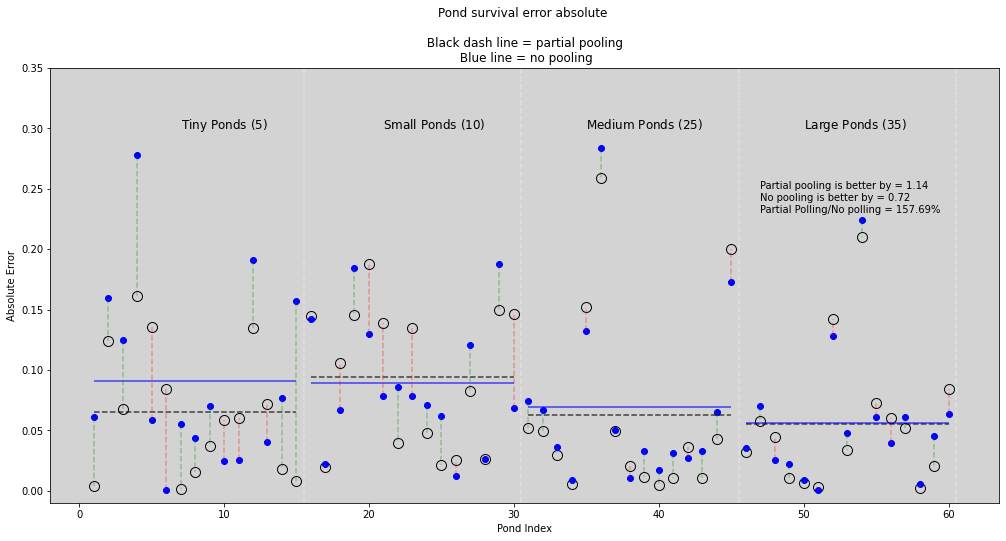

In [34]:
plt.figure(figsize=(17, 8))
plt.ylim = ([0, 1])
max_lim_graph = 0.3

plt.scatter(dsim.pond, partpool_error, edgecolors='black', c='lightgray', s=100)
plt.scatter(dsim.pond, no_pool_error, c='blue')

qty_unique_ponds = len(dsim['Ni'].unique())
qty_each_ponds = repeats  # The number of repetitions for each element in each pond.


# Vertical lines
for i in range(qty_unique_ponds):
    plt.axvline(x=qty_each_ponds*(i+1) + 0.5, ls='--', color='white', alpha=0.3)
    
    partpool_error_mean = np.mean(partpool_error[(qty_each_ponds*i):(qty_each_ponds*(i+1))])
    no_pool_error_mean = np.mean(no_pool_error[(qty_each_ponds*i):(qty_each_ponds*(i+1))])
    
    plt.hlines(y=partpool_error_mean, xmin=1+(qty_each_ponds*i), xmax=qty_each_ponds+(qty_each_ponds*i), ls='--', colors='black', alpha=0.7)
    plt.hlines(y=no_pool_error_mean, xmin=1+(qty_each_ponds*i), xmax=qty_each_ponds+(qty_each_ponds*i), ls='-', colors='blue', alpha=0.7)

score_no_pooling = 0
score_partial_pooling = 0
    
for i in dsim.pond:
    if no_pool_error[i-1] >= partpool_error[i-1]:  # partial polling is better
        plt.vlines(x=i, ymin=no_pool_error[i-1], ymax=partpool_error[i-1], ls='--', colors='green', alpha=0.3)
        score_partial_pooling += no_pool_error[i-1] - partpool_error[i-1]  # How partial pooling is better
        
    else:  # no pooling is better
        plt.vlines(x=i, ymin=no_pool_error[i-1], ymax=partpool_error[i-1], ls='--', colors='red', alpha=0.3)
        score_no_pooling += partpool_error[i-1] - no_pool_error[i-1]  # How no pooling is better

plt.text(7, max_lim_graph, 'Tiny Ponds ($5$)', size=12)
plt.text(21, max_lim_graph, 'Small Ponds ($10$)', size=12)
plt.text(35, max_lim_graph, 'Medium Ponds ($25$)', size=12)
plt.text(50, max_lim_graph, 'Large Ponds ($35$)', size=12)

plt.text(47, 0.25, f'Partial pooling is better by = {round(score_partial_pooling, 2)}')
plt.text(47, 0.24, f'No pooling is better by = {round(score_no_pooling, 2)}')
plt.text(47, 0.23, f'Partial Polling/No polling = {round((score_partial_pooling/score_no_pooling)*100, 2)}%')


plt.gca().set_ylim(-0.01, max_lim_graph + 0.05)

plt.title('Pond survival error absolute \n\n Black dash line = partial pooling \n Blue line = no pooling')
plt.xlabel('Pond Index')
plt.ylabel('Absolute Error')

plt.show()

### R Code 13.20

In [35]:
# Reuse code in using Rethinking packages in R, here is automatically reuse!
# Just re-run from R Code 13.7

## 13.3 More than one type of cluster

#### Multilevel Chimpanzees

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \gamma_{BLOCK[i]} + \beta_{TREATMENT[i]} $$

$$ \beta_j \sim Normal(0, 0.5) \mbox{  , } j \in \{1, ... ,4\} $$

$$ \alpha_j \sim Normal(\bar{\alpha}, \sigma_\alpha) \mbox{  , } j \in \{1, ... ,7\} $$

$$ \gamma_j \sim Normal(0, \sigma_\gamma) \mbox{  , } j \in \{1, ... ,6\} $$

$$ \bar{\alpha} \sim Normal(0, 1.5) $$

$$ \sigma_{\alpha} \sim Exponential(1) $$

$$ \sigma_{\gamma} \sim Exponential(1) $$

### R Code 13.21

In [36]:
# Previous chimpanzees models is in chapter 11

df = pd.read_csv('./data/chimpanzees.csv', sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [37]:
df['treatment'] = 1 + df['prosoc_left'] + 2 * df['condition']
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,1
1,1,NaN,0,1,4,0,0,1,1
2,1,NaN,0,1,6,1,0,0,2
3,1,NaN,0,1,8,0,1,0,1
4,1,NaN,0,1,10,1,1,1,2


In [38]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_blocks;
        int qty_treatments;
        
        array[N] int pulled_left;
        array[N] int actor;
        array[N] int block;
        array[N] int treatment;
    }
    
    parameters {
        vector[qty_treatments] beta;
        
        vector[qty_chimpanzees] alpha;
        real bar_alpha;
        real<lower=0> sigma_alpha;
        
        vector[qty_blocks] gamma;
        real<lower=0>  sigma_gamma;
           
    }
    
    model {
        vector[N] p;
    
        // priors
        beta ~ normal(0, 0.5);
        
        alpha ~ normal(bar_alpha, sigma_alpha);
        bar_alpha ~ normal(0, 1.5);
        sigma_alpha ~ exponential(1);
        
        gamma ~ normal(0, sigma_gamma);
        sigma_gamma ~ exponential(1);
        
        // link
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + gamma[ block[i] ] + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // linkelihood
        pulled_left ~ binomial(1, p);
    }

"""

dat_list = df[['pulled_left', 'actor', 'block', 'treatment']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_chimpanzees'] = len(df['actor'].unique())
dat_list['qty_blocks'] = len(df['block'].unique())
dat_list['qty_treatments'] = len(df['treatment'].unique())

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (301/8000)
Sampling:   9% (700/8000)
Sampling:  14% (1100/8000)
Sampling:  18% (1400/8000)
Sampling:  21% (1700/8000)
Sampling:  25% (2000/8000)
Sampling:  29% (2300/8000)
Sampling:  32% (2600/8000)
Sampling:  52% (4200/8000)
Sampling:  69% (5500/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000119 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000119 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.19 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale paramet

### R Code 13.22

In [39]:
model_13_4 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list
)

In [40]:
az.summary(model_13_4, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.178,0.296,-0.569,0.352,0.042,0.030,54.0,1029.0,1.06
beta[1],0.332,0.321,-0.083,0.828,0.077,0.056,20.0,1608.0,1.14
beta[2],-0.537,0.308,-0.994,-0.069,0.059,0.043,31.0,1329.0,1.09
beta[3],0.232,0.297,-0.221,0.702,0.046,0.033,45.0,1159.0,1.06
alpha[0],-0.263,0.405,-0.829,0.320,0.106,0.077,17.0,1605.0,1.17
alpha[1],4.763,1.249,2.811,6.460,0.035,0.025,1182.0,1293.0,1.03
alpha[2],-0.624,0.347,-1.205,-0.104,0.021,0.024,400.0,1396.0,1.03
alpha[3],-0.588,0.393,-1.237,-0.112,0.085,0.061,24.0,1595.0,1.12
alpha[4],-0.275,0.387,-0.899,0.220,0.092,0.066,20.0,860.0,1.14
alpha[5],0.620,0.353,0.033,1.161,0.016,0.011,507.0,1421.0,1.03


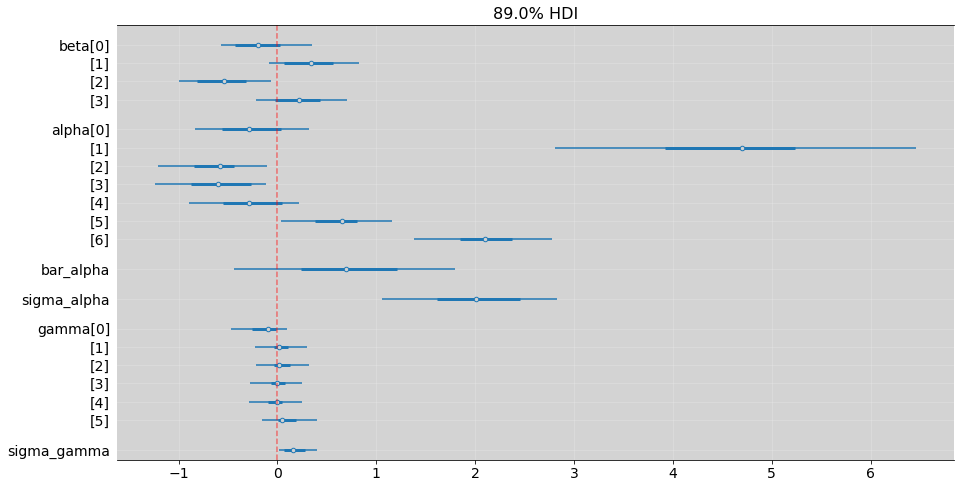

In [41]:
az.plot_forest(model_13_4, hdi_prob=0.89, combined=True, figsize=(15, 8))
plt.grid('--', color='white', alpha=0.2)
plt.axvline(x=0, color='red', alpha=0.5, ls='--')
plt.show()

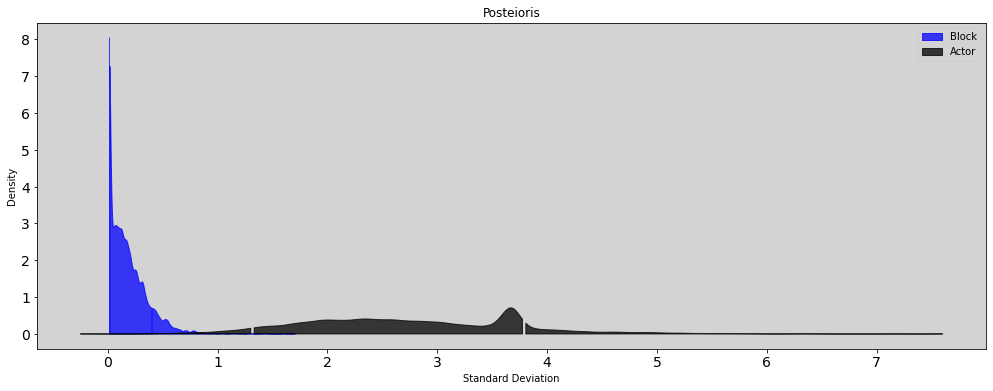

In [42]:
plt.figure(figsize=(17, 6))

az.plot_dist(
    [model_13_4.posterior.sigma_gamma], color='blue', quantiles=[.05, .89]
)

az.plot_dist(
    [model_13_4.posterior.bar_alpha + model_13_4.posterior.sigma_alpha],
    color='black', quantiles=[.05, .89]
)

plt.legend(['Block', 'Actor'])
plt.title('Posteioris')
plt.ylabel('Density')
plt.xlabel('Standard Deviation')
plt.show()

###  R Code 13.23

In [43]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_blocks;
        int qty_treatments;
        
        array[N] int pulled_left;
        array[N] int actor;
        array[N] int block;
        array[N] int treatment;
    }
    
    parameters {
        vector[qty_treatments] beta;
        
        vector[qty_chimpanzees] alpha;
        real bar_alpha;
        real<lower=0> sigma_alpha;   
    }
    
    model {
        vector[N] p;
    
        // priors
        beta ~ normal(0, 0.5);
        
        alpha ~ normal(bar_alpha, sigma_alpha);
        bar_alpha ~ normal(0, 1.5);
        sigma_alpha ~ exponential(1);
        
        // link
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // linkelihood
        pulled_left ~ binomial(1, p);
    }

"""

dat_list = df[['pulled_left', 'actor', 'block', 'treatment']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_chimpanzees'] = len(df['actor'].unique())
dat_list['qty_blocks'] = len(df['block'].unique())
dat_list['qty_treatments'] = len(df['treatment'].unique())

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   9% (700/8000)
Sampling:  15% (1200/8000)
Sampling:  40% (3200/8000)
Sampling:  62% (5000/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000102 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.02 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_rpq3tyko/model_r7i3x47h.stan', line 28, column 8 to column 47)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

In [44]:
model_13_5 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys()
)

### R Code 13.24

In [45]:
# az.compare(model_13_4, model_13_5)

### R Code 13.25

In [46]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_blocks;
        int qty_treatments;
        
        array[N] int pulled_left;
        array[N] int actor;
        array[N] int block;
        array[N] int treatment;
    }
    
    parameters {
        vector[qty_treatments] beta;
        real<lower=0>  sigma_beta;

        vector[qty_chimpanzees] alpha;
        real bar_alpha;
        real<lower=0> sigma_alpha;
        
        vector[qty_blocks] gamma;
        real<lower=0>  sigma_gamma;
        
    }
    
    model {
        vector[N] p;
    
        // priors
        beta ~ normal(0, sigma_beta);
        sigma_beta ~ exponential(1);
        
        alpha ~ normal(bar_alpha, sigma_alpha);
        bar_alpha ~ normal(0, 1.5);
        sigma_alpha ~ exponential(1);
        
        gamma ~ normal(0, sigma_gamma);
        sigma_gamma ~ exponential(1);
        
        // link
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + gamma[ block[i] ] + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // linkelihood
        pulled_left ~ binomial(1, p);
    }

"""

dat_list = df[['pulled_left', 'actor', 'block', 'treatment']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_chimpanzees'] = len(df['actor'].unique())
dat_list['qty_blocks'] = len(df['block'].unique())
dat_list['qty_treatments'] = len(df['treatment'].unique())

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (301/8000)
Sampling:   6% (500/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  15% (1200/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  28% (2200/8000)
Sampling:  31% (2500/8000)
Sampling:  36% (2900/8000)
Sampling:  55% (4400/8000)
Sampling:  71% (5700/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000122 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.22 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_59n9gjpm/model_ncxzodym.stan', line 31

In [47]:
model_13_6 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys()
)

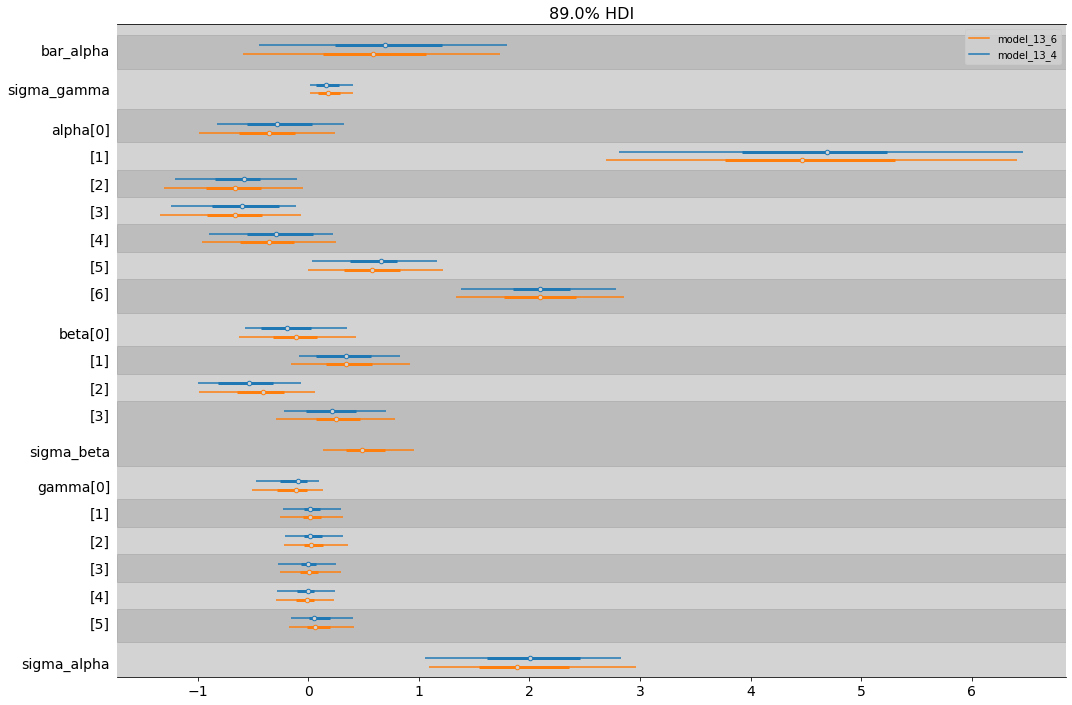

In [48]:
az.plot_forest([model_13_4, model_13_6], combined=True, figsize=(17,12), hdi_prob=0.89,
              model_names = ["model_13_4", "model_13_6"])
plt.show()

## 13.4 Divergent Transitions and non-centered priors

### R Code 13.26

In [49]:
model = """
    parameters {
        real v;
        real x;
    }
    
    model {
        v ~ normal(0, 3);
        x ~ normal(0, exp(v));
    }
"""

posteriori = stan.build(model)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!


In [50]:
model_13_5 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
)

In [51]:
az.summary(model_13_5, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,3.515,1.508,1.243,5.486,0.208,0.148,37.0,26.0,1.1
x,-34.371,286.623,-142.353,209.821,20.340,14.404,290.0,232.0,1.1


### R Code 13.27

In [52]:
model = """
    parameters {
        real v;
        real z;
    }
    
    model {
        v ~ normal(0, 3);
        z ~ normal(0, 1);
    }
    
    generated quantities {
        real x;
        
        x = z*exp(v);
    }
"""

posteriori = stan.build(model)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!


In [53]:
model_13_6 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
)

In [54]:
az.summary(model_13_6, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.055,2.991,-4.401,5.018,0.050,0.048,3573.0,2181.0,1.0
z,0.018,0.998,-1.515,1.663,0.018,0.015,3015.0,2616.0,1.0
x,4.028,3223.155,-22.220,30.356,50.982,36.052,2943.0,2668.0,1.0


#### 13.4.2 Non-centered chimpanzees

### R Code 13.28

In [55]:
# Don't have apapt_delta in pystan3, until today.

### R Code 13.29

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \bar{\alpha} + z_{ACTOR[i]} \sigma_\alpha + x_{BLOCK[i]}\sigma_\gamma + \beta_{TREATMENT[i]} $$

To Actor:
$$ \bar{\alpha} \sim Normal(0, 1.5) $$

$$ z_j \sim Normal(0, 1) $$

$$ \sigma_\alpha \sim Exponential(1) $$



To Block:

$$ x_j \sim Normal(0, 1) $$

$$ \sigma_\gamma \sim Exponential(1) $$


To Treatment:

$$ \beta_j \sim Normal(0, 0.5) $$


Where, each actor is defined by:

$$ \alpha_j = \bar{\alpha} + z_j\sigma_\alpha  $$

and, each block is defined by:

$$ \gamma_j = x_j\sigma_\gamma $$

In [56]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_blocks;
        int qty_treatments;
        
        array[N] int pulled_left;
        array[N] int actor;
        array[N] int block;
        array[N] int treatment;
    }
    
    parameters {
        // To treatments
        vector[qty_treatments] beta;
        
        // To actors
        real bar_alpha;
        vector[qty_chimpanzees] z;
        real<lower=0> sigma_alpha;
        
        // To block
        vector[qty_blocks] x;
        real<lower=0>  sigma_gamma;
    }
    
    model {
        vector[N] p;
    
        // priors
        beta ~ normal(0, 0.5);  // treatment
        z ~ normal(0, 1);  // actor
        x ~ normal(0, 1);  // block 
        
        bar_alpha ~ normal(0, 1.5);  // Intercept to alpha (actor)
        
        sigma_alpha ~ exponential(1);
        sigma_gamma ~ exponential(1);
        
        // Link
        for (i in 1:N){
            p[i] = bar_alpha  + z[ actor[i] ]*sigma_alpha +  x[ block[i] ]*sigma_gamma + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Linkelihood
        pulled_left ~ binomial(1, p);
    }
    
    generated quantities {
        vector[qty_chimpanzees] alpha;
        vector[qty_blocks] gamma;
        
        alpha = bar_alpha + z*sigma_alpha;
        gamma = x*sigma_gamma;
    }

"""

dat_list = df[['pulled_left', 'actor', 'block', 'treatment']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_chimpanzees'] = len(df['actor'].unique())
dat_list['qty_blocks'] = len(df['block'].unique())
dat_list['qty_treatments'] = len(df['treatment'].unique())

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  42% (3400/8000)
Sampling:  56% (4500/8000)
Sa

In [57]:
model_13_4_nc = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys()
)

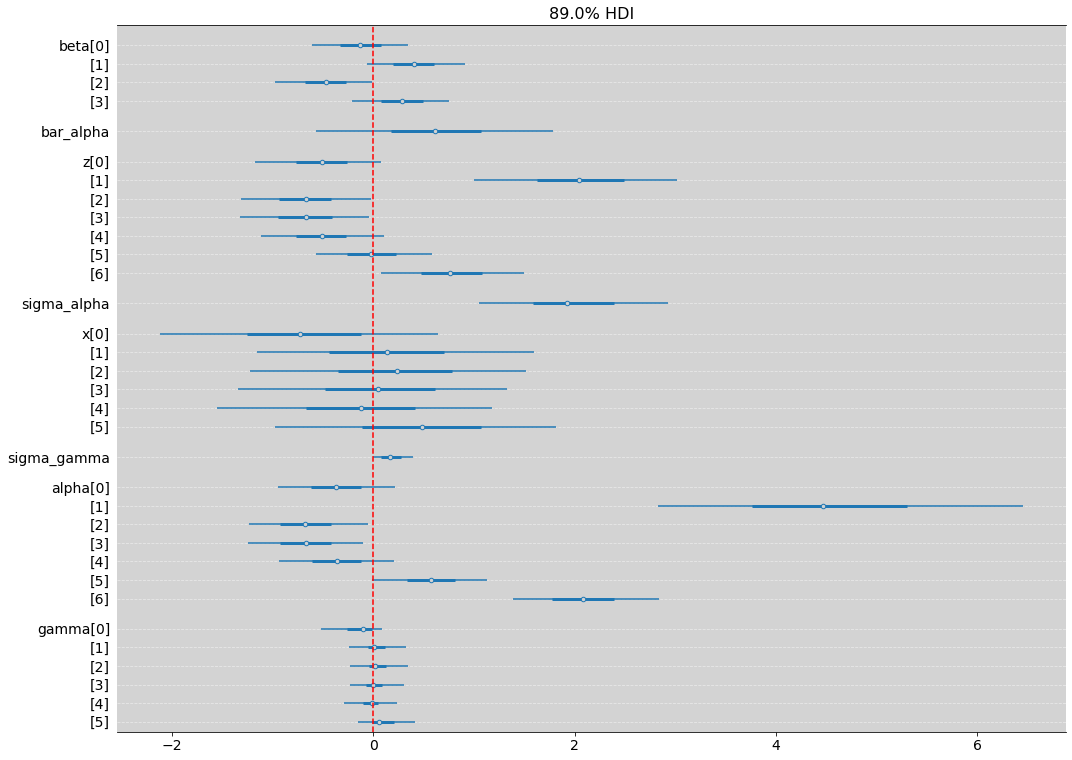

In [58]:
az.plot_forest(model_13_4_nc, hdi_prob=0.89, combined=True, figsize=(17, 13))

plt.axvline(x=0, ls='--', color='red')
plt.grid(axis='y', color='white', ls='--', alpha=0.5)
plt.show()

### R Code 13.30

In [59]:
# Extract features from ess

# non-centered
ess_nc = np.array(az.ess(model_13_4_nc, var_names=['alpha']).alpha.values)
ess_nc = np.append(ess_nc, az.ess(model_13_4_nc, var_names=['beta']).beta.values)
ess_nc = np.append(ess_nc, az.ess(model_13_4_nc, var_names=['gamma']).gamma.values)
ess_nc = np.append(ess_nc, az.ess(model_13_4_nc, var_names=['bar_alpha']).bar_alpha.values)
ess_nc = np.append(ess_nc, az.ess(model_13_4_nc, var_names=['sigma_alpha']).sigma_alpha.values)
ess_nc = np.append(ess_nc, az.ess(model_13_4_nc, var_names=['sigma_gamma']).sigma_gamma.values)

# centered
ess_c = np.array(az.ess(model_13_4, var_names=['alpha']).alpha.values)
ess_c = np.append(ess_c, az.ess(model_13_4, var_names=['beta']).beta.values)
ess_c = np.append(ess_c, az.ess(model_13_4, var_names=['gamma']).gamma.values)
ess_c = np.append(ess_c, az.ess(model_13_4, var_names=['bar_alpha']).bar_alpha.values)
ess_c = np.append(ess_c, az.ess(model_13_4, var_names=['sigma_alpha']).sigma_alpha.values)
ess_c = np.append(ess_c, az.ess(model_13_4, var_names=['sigma_gamma']).sigma_gamma.values)

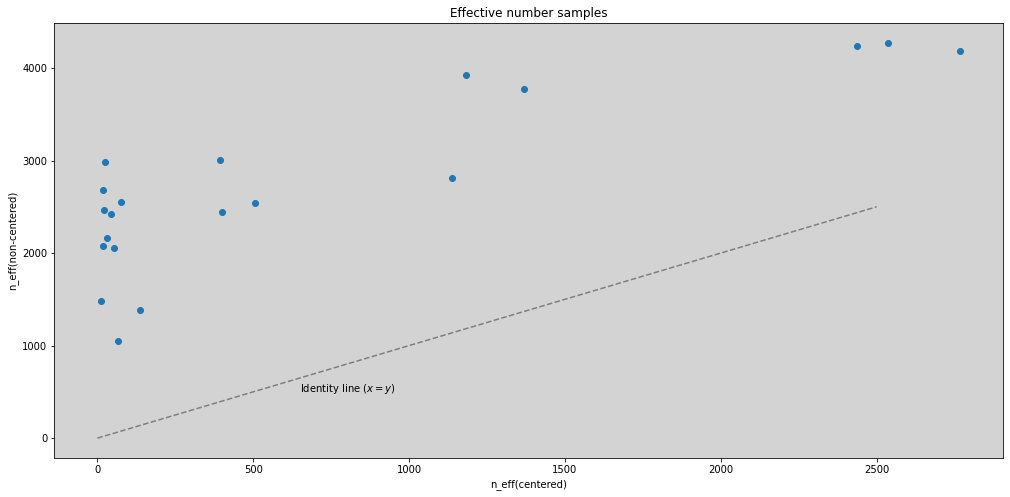

In [60]:
plt.figure(figsize=(17, 8))

plt.scatter(ess_c, ess_nc)

plt.plot([0, 2500], [0, 2500], ls='--', c='k', alpha=0.4)
plt.text(650, 500, 'Identity line ($x=y$)')

plt.title('Effective number samples')
plt.xlabel('n_eff(centered)')
plt.ylabel('n_eff(non-centered)')

plt.show()